# Credit scoring

Crédito não tem a ver somente com cartões de crédito. Está em outras atividades como financiamento de automóveis e imóveis, além de empréstimos pessoais e consignados. 

Conceder crédito envolve risco de inadimplência. Por isso, para as instituições financeira é importante uma boa análise para tomar a decisão sobre conceder ou não um crédito a uma pessoa tomadora, bem como o limite a ser concedido e as condições para concessão. 

O chamado "*credit scoring*" é um modelo estatístico de decisão que auxilia na aprovação ou não um pedido de crédito, cuja saída é uma probabilidade de a pessoa tomadora se tornar **inadimplente**. Desse modo, podemos defini-lo como um problema de **classificação binária**, então podemos utilizar algoritmos de ML para classificação para criar um modelo de credit scoring.

Neste curso, usaremos a **regressão logística**, uma técnica muito usada no sistema financeiro e que possui boa "explicabilidade" (conseguimos ver detalhes de como o modelo chegou à decisão), além de exigir pouco poder computacional quando comparado a outras técnicas.

## Base de dados

A base é uma versão adaptada e traduzida da base ["German Credit Data"](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) da UCI. 

(a tradução parece ser só dos nomes das colunas...)

In [1]:
import pandas as pd

df = pd.read_csv('./base_dados_traduzida.csv')
df.head()

,default,conta_corrente,prazo_emprestimo_meses,historico_credito,proposito_emprestimo,valor_emprestimo,reserva_cc,tempo_emprego_atual,taxa_comp_salario,sexo_est_civil,...,anos_residencia_atual,propriedade,idade,outros_planos_financiamento,tipo_residencia,n_creditos_banco,status_emprego,n_dependentes,telefone,trabalhador_estrangeiro
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   default                      1000 non-null   int64 
 1   conta_corrente               1000 non-null   object
 2   prazo_emprestimo_meses       1000 non-null   int64 
 3   historico_credito            1000 non-null   object
 4   proposito_emprestimo         1000 non-null   object
 5   valor_emprestimo             1000 non-null   int64 
 6   reserva_cc                   1000 non-null   object
 7   tempo_emprego_atual          1000 non-null   object
 8   taxa_comp_salario            1000 non-null   int64 
 9   sexo_est_civil               1000 non-null   object
 10  outros_fiadores              1000 non-null   object
 11  anos_residencia_atual        1000 non-null   int64 
 12  propriedade                  1000 non-null   object
 13  idade                        1000 

In [3]:
df.shape

(1000, 21)

In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum().sum()

0

Temos uma base de dados sem dados nulos ou duplicados, com 1000 entradas e 21 colunas. A variável alvo é a primeira da base e se chama `default`.

## Codificação das variáveis categóricas

A regressão logística trabalha somente com dados numéricos, então precisamos transformar as variáveis categóricas. 

A instrutora usa uma versão manual de ordinal encoding, que, a meu ver, não deveria ser utilizada pois cria uma ordem de grandeza entre as categorias, o que pode enviesar o modelo (algo que foi bem fundamentado por um aluno [em uma postagem no fórum](https://cursos.alura.com.br/forum/topico-tratamento-de-variaveis-categoricas-244803)). Eu optei pelo OneHotEncoding. Além disso, no curso ela codifica as variáveis após já ter feito a divisão dos dados em treino e teste (só em um vídeo posterior ela refaz esses passos).

In [6]:
cat_cols = df.select_dtypes(include=[object]).columns
cat_cols

Index(['conta_corrente', 'historico_credito', 'proposito_emprestimo',
       'reserva_cc', 'tempo_emprego_atual', 'sexo_est_civil',
       'outros_fiadores', 'propriedade', 'outros_planos_financiamento',
       'tipo_residencia', 'status_emprego', 'telefone',
       'trabalhador_estrangeiro'],
      dtype='object')

In [7]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(drop='if_binary')

cat_encoded = onehot.fit_transform(df[cat_cols])

df_cat = pd.DataFrame(cat_encoded.toarray(), columns=onehot.get_feature_names_out(cat_cols))
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 52 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   conta_corrente_0 <= ... < 200 DM                                               1000 non-null   float64
 1   conta_corrente_< 0 DM                                                          1000 non-null   float64
 2   conta_corrente_>= 200 DM / salary assignments for at least 1 year              1000 non-null   float64
 3   conta_corrente_no checking account                                             1000 non-null   float64
 4   historico_credito_all credits at this bank paid back duly                      1000 non-null   float64
 5   historico_credito_critical account/ other credits existing (not at this bank)  1000 non-null   float64
 6   historico_credito_delay i

In [8]:
df_enc = pd.concat([df.drop(cat_cols, axis=1), df_cat], axis=1)
df_enc.head()

,default,prazo_emprestimo_meses,valor_emprestimo,taxa_comp_salario,anos_residencia_atual,idade,n_creditos_banco,n_dependentes,conta_corrente_0 <= ... < 200 DM,conta_corrente_< 0 DM,...,outros_planos_financiamento_stores,tipo_residencia_for free,tipo_residencia_own,tipo_residencia_rent,status_emprego_management/ self-employed/ highly qualified employee/ officer,status_emprego_skilled employee / official,status_emprego_unemployed/ unskilled - non-resident,status_emprego_unskilled - resident,"telefone_yes, registered under the customers name",trabalhador_estrangeiro_yes
0,0,6,1169,4,4,67,2,1,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,1,48,5951,2,2,22,1,1,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,12,2096,2,3,49,1,2,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,42,7882,2,4,45,1,2,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,24,4870,3,4,53,2,2,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [9]:
y = df_enc['default']
X = df_enc.drop(columns='default')

In [10]:
from sklearn.model_selection import train_test_split

SEED = 77
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=SEED)

## Primeiro modelo de regressão logística

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [12]:
model.score(X_test, y_test)

0.7533333333333333

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       214
           1       0.59      0.48      0.53        86

    accuracy                           0.75       300
   macro avg       0.70      0.67      0.68       300
weighted avg       0.74      0.75      0.75       300



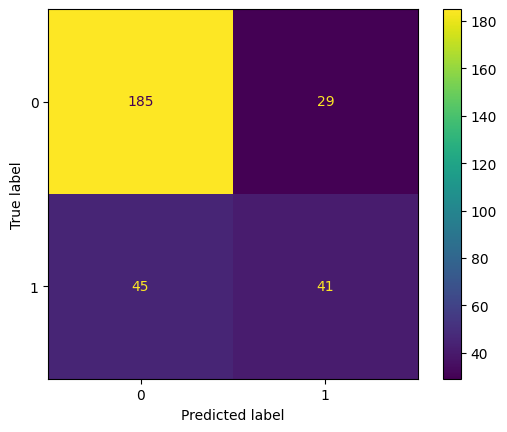

In [13]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

Avaliando o modelo pela curva ROC. 

Relembrando, a curva ROC é plotada em um gráfico fpr x tpr (false positive rate ou especificidade, e true positive rate ou sensibilidade). Quanto mais próxima sua "ponta" estiver do topo esquerdo do eixo Y, melhor o modelo está acertando a classe alvo, ou seja, melhor está sendo a sensibilidade.

Convenção estatística para a AUC:

- área < 0,7: baixa discriminiação

- 0,7 <= área < 0,8: discriminação aceitável

- 0,8 <= área < 0,9: discriminação excelente

- área >= 0,9: discriminação excepcional

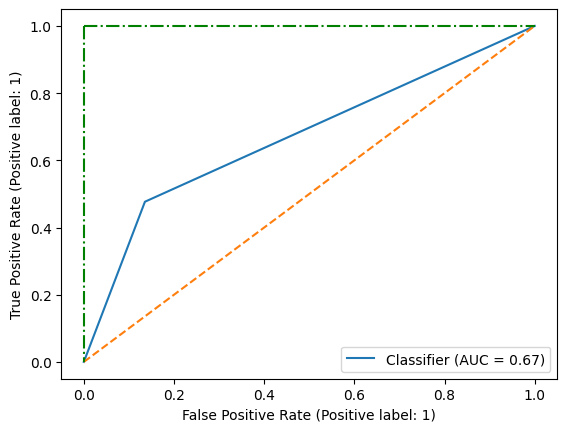

In [14]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], ls='-.', c='green')
plt.plot([1, 1], ls='-.', c='green');

Meu modelo está com baixa discriminação. O modelo feito pela instrutora (com Label Encoder) está com AUC = 0.8194, excelente.

## Análise descritiva

Vamos verificar algumas variáveis (colunas) da base de dados.

In [15]:
df.columns

Index(['default', 'conta_corrente', 'prazo_emprestimo_meses',
       'historico_credito', 'proposito_emprestimo', 'valor_emprestimo',
       'reserva_cc', 'tempo_emprego_atual', 'taxa_comp_salario',
       'sexo_est_civil', 'outros_fiadores', 'anos_residencia_atual',
       'propriedade', 'idade', 'outros_planos_financiamento',
       'tipo_residencia', 'n_creditos_banco', 'status_emprego',
       'n_dependentes', 'telefone', 'trabalhador_estrangeiro'],
      dtype='object')

In [16]:
selected_cols = ['idade', 'prazo_emprestimo_meses', 'valor_emprestimo']
df[selected_cols].describe()

,idade,prazo_emprestimo_meses,valor_emprestimo
count,1000.000000,1000.000000,1000.000000
mean,35.546000,20.903000,3271.258000
std,11.375469,12.058814,2822.736876
min,19.000000,4.000000,250.000000
25%,27.000000,12.000000,1365.500000
50%,33.000000,18.000000,2319.500000
75%,42.000000,24.000000,3972.250000
max,75.000000,72.000000,18424.000000


In [17]:
df['sexo_est_civil'].value_counts() 

male : single                          548
female : divorced/separated/married    310
male : married/widowed                  92
male : divorced/separated               50
Name: sexo_est_civil, dtype: int64

Nossa base possui mais pessoas do sexo masculino (690) do que feminino (310).

In [18]:
df['default'].value_counts() # 700 

0    700
1    300
Name: default, dtype: int64

A variável-alvo na base está desbalanceada, com 30% dos dados sendo de pessoas classificadas como inadimplentes.

---

Usando seaborn e matplotlib para visualizar alguns gráficos:

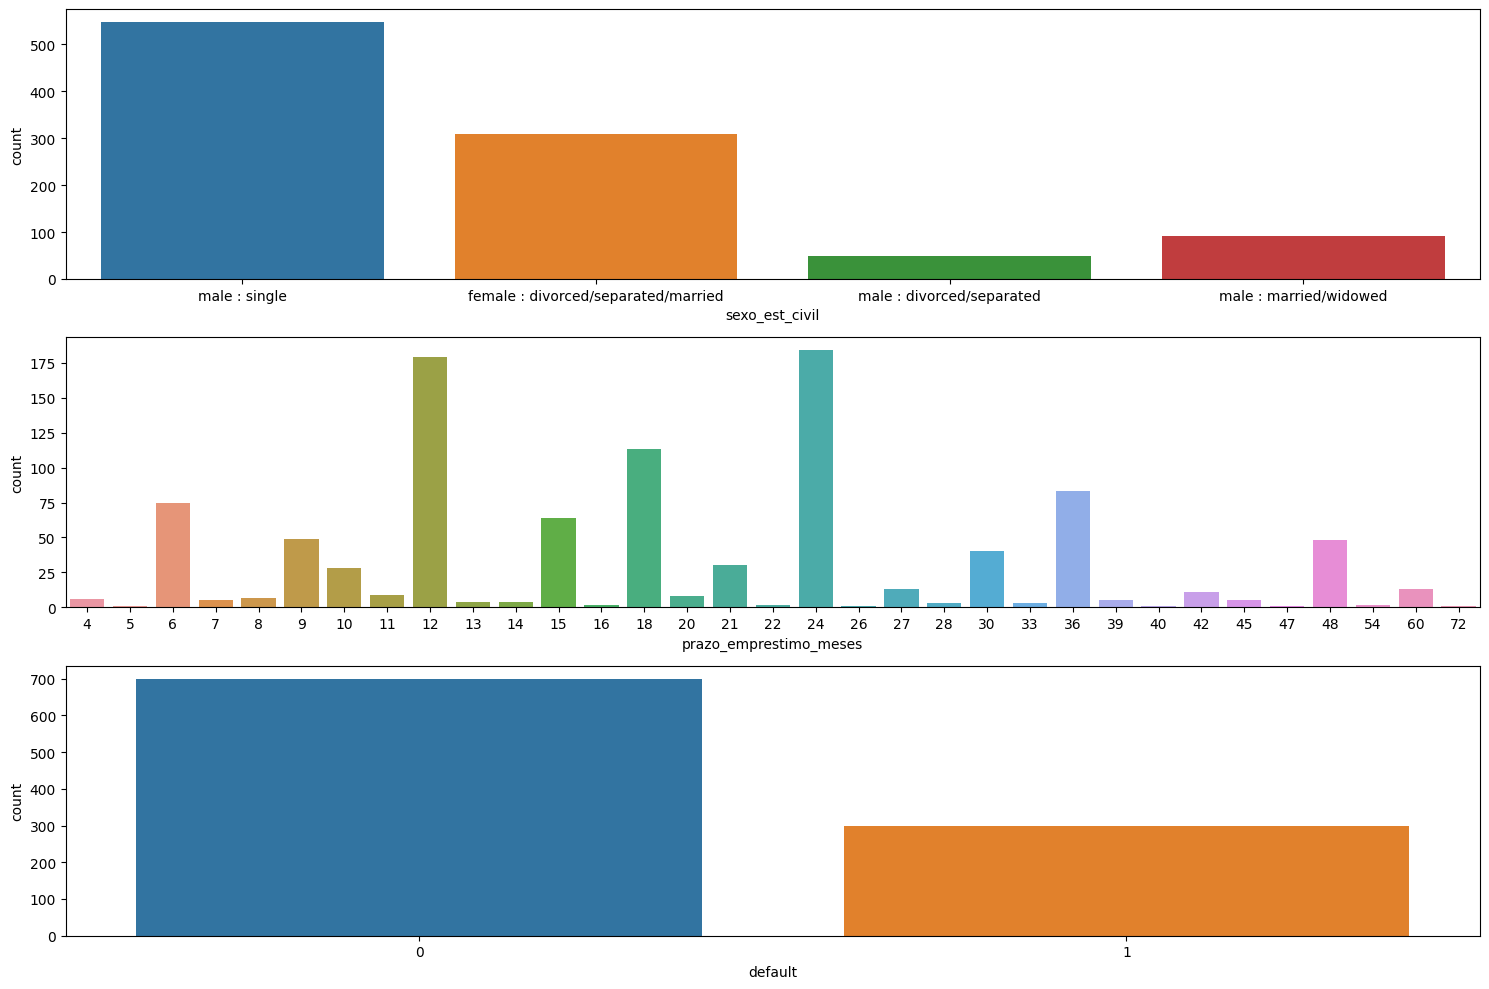

In [19]:
import seaborn as sns

hist_cols = ['sexo_est_civil', 'prazo_emprestimo_meses', 'default']

fig, axes = plt.subplots(3, 1, figsize=(15, 10))
[sns.countplot(x=df[hist_cols[i]], ax=axes[i]) for i in range(len(hist_cols))]
plt.tight_layout();


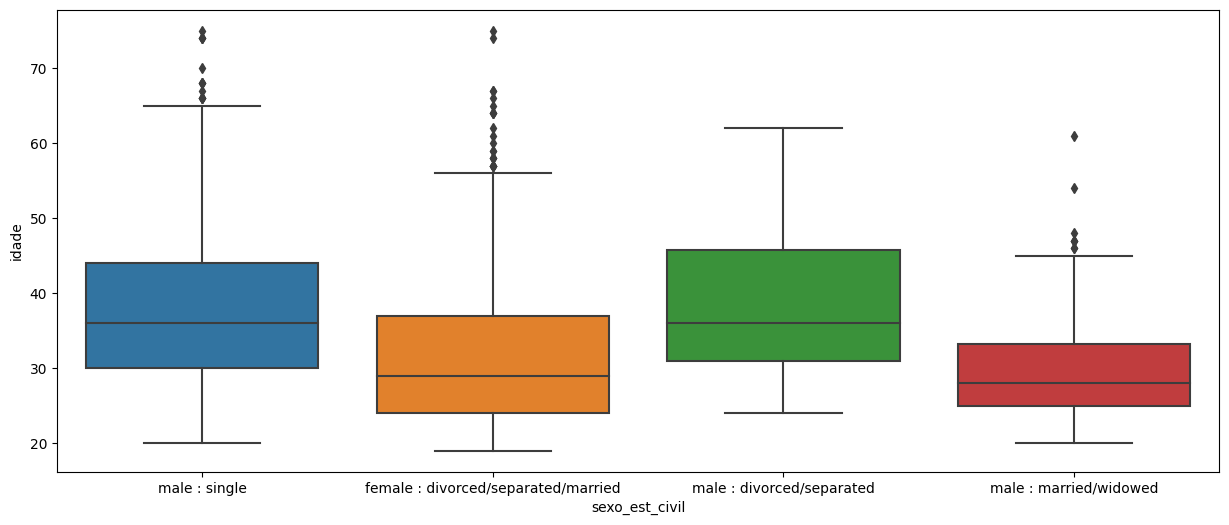

In [20]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='sexo_est_civil', y='idade');

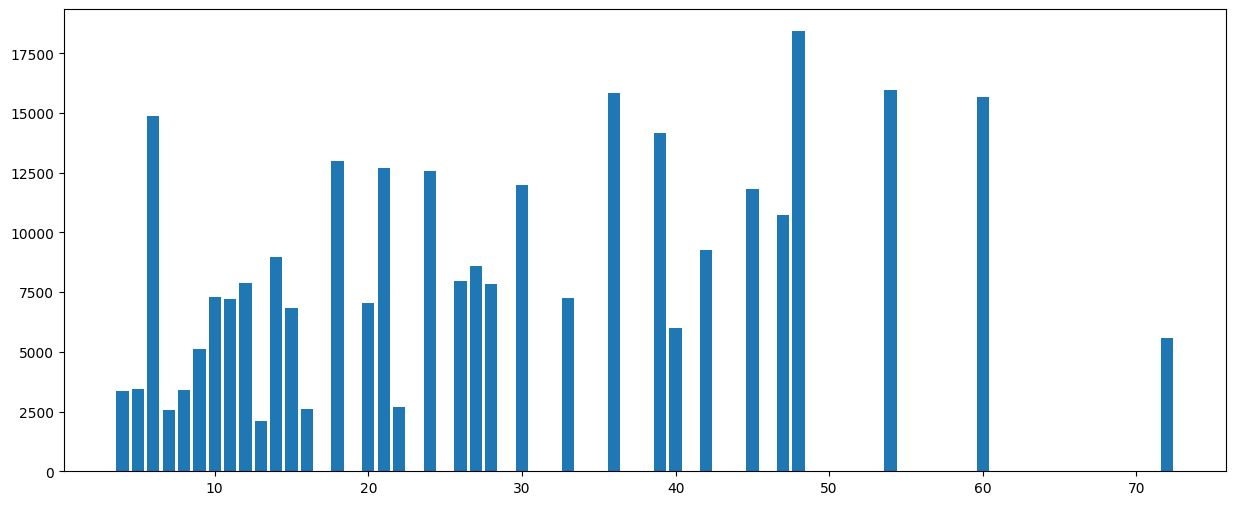

In [21]:
plt.figure(figsize=(15, 6))
# sns.barplot(data=df, x='prazo_emprestimo_meses', y='valor_emprestimo')
plt.bar(df['prazo_emprestimo_meses'], df['valor_emprestimo']);

## Informações sensíveis

Dados de gênero e estado civil da pessoa podem ser considerados informações sensíveis. Apesar disso, essas variáveis são relevantes ao modelo. Vamos remover o gênero da base de dados, mas manter o estado civil de maneira não estruturada, ou seja, sem dividir essa informação entre homens e mulheres, desse modo impedindo que o modelo tenha algum viés por um gênero, favorecendo/desfavorecendo um em relação ao outro.

Será criada uma nova variável estado_civil, com duas categorias possíveis: 0 - pessoa casada/divorciada/viúva e 1- pessoa solteira.

In [26]:
df['sexo_est_civil'].value_counts()

male : single                          548
female : divorced/separated/married    310
male : married/widowed                  92
male : divorced/separated               50
Name: sexo_est_civil, dtype: int64

In [27]:
dic_est_civil = {
    'male : single': 1,
    'female : divorced/separated/married': 0,
    'male : married/widowed': 0,
    'male : divorced/separated': 0,
}

df_enc['estado_civil'] = df['sexo_est_civil'].map(dic_est_civil)

,default,prazo_emprestimo_meses,valor_emprestimo,taxa_comp_salario,anos_residencia_atual,idade,n_creditos_banco,n_dependentes,conta_corrente_0 <= ... < 200 DM,conta_corrente_< 0 DM,...,tipo_residencia_for free,tipo_residencia_own,tipo_residencia_rent,status_emprego_management/ self-employed/ highly qualified employee/ officer,status_emprego_skilled employee / official,status_emprego_unemployed/ unskilled - non-resident,status_emprego_unskilled - resident,"telefone_yes, registered under the customers name",trabalhador_estrangeiro_yes,estado_civil
0,0,6,1169,4,4,67,2,1,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1
1,1,48,5951,2,2,22,1,1,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2,0,12,2096,2,3,49,1,2,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
3,0,42,7882,2,4,45,1,2,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4,1,24,4870,3,4,53,2,2,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1


In [33]:
cols_to_show = [
    'sexo_est_civil_female : divorced/separated/married',
    'sexo_est_civil_male : divorced/separated',
    'sexo_est_civil_male : married/widowed', 
    'sexo_est_civil_male : single',
    'estado_civil'
]
df_enc[cols_to_show].head()

,sexo_est_civil_female : divorced/separated/married,sexo_est_civil_male : divorced/separated,sexo_est_civil_male : married/widowed,sexo_est_civil_male : single,estado_civil
0,0.0,0.0,0.0,1.0,1
1,1.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,1.0,1
3,0.0,0.0,0.0,1.0,1
4,0.0,0.0,0.0,1.0,1


In [34]:
print(f'Before {df_enc.shape}')
cols_to_drop = [
    'sexo_est_civil_female : divorced/separated/married',
    'sexo_est_civil_male : divorced/separated',
    'sexo_est_civil_male : married/widowed', 
    'sexo_est_civil_male : single'
]
df_enc.drop(cols_to_drop, axis=1, inplace=True)
print(f'After {df_enc.shape}')

Before (1000, 61)
After (1000, 57)


## Pipeline para criar novos modelos

Vamos criar uma função que vai se comportar como um pipeline, reproduzindo todos os passos para separação da base, treinamento do modelo e validação. Desse modo, podemos reutilizá-la com diferentes dados e modelos.

In [43]:
def run_classifier(data, classifier):
    SEED = 77
    y = data['default']
    X = data.drop(columns='default')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=SEED)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title('Matriz de confusão')
    plt.show()
    print('-'*100)
    print('Métricas:')
    print(classification_report(y_test, y_pred))
    print('-'*100)
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.plot([0, 1], ls='--')
    plt.plot([0, 0], [1, 0], ls='-.', c='green')
    plt.plot([1, 1], ls='-.', c='green')
    plt.title('Curva ROC e AUC')
    plt.show();

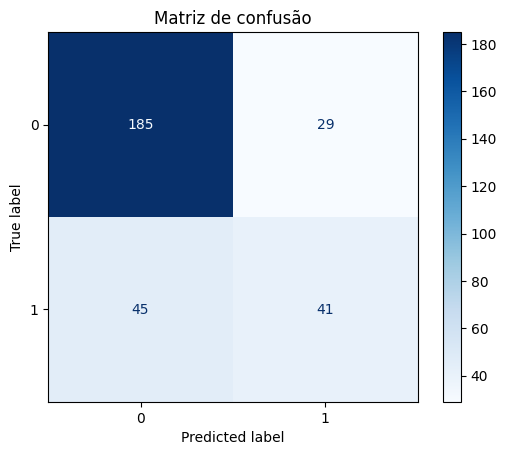

----------------------------------------------------------------------------------------------------
Métricas:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       214
           1       0.59      0.48      0.53        86

    accuracy                           0.75       300
   macro avg       0.70      0.67      0.68       300
weighted avg       0.74      0.75      0.75       300

----------------------------------------------------------------------------------------------------


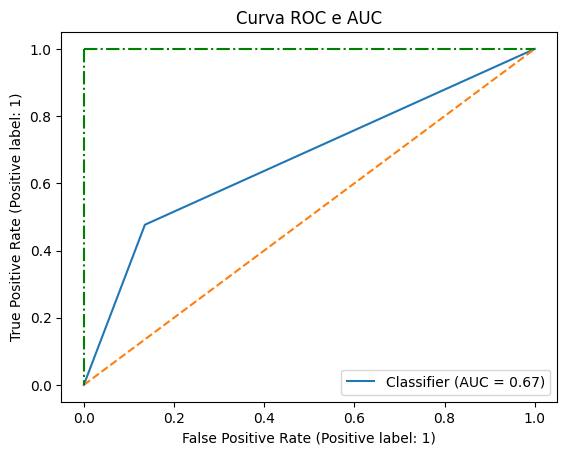

In [44]:
run_classifier(df_enc, LogisticRegression(max_iter=1000))

Testando um modelo com um dataset menor, selecionando somente algumas colunas.

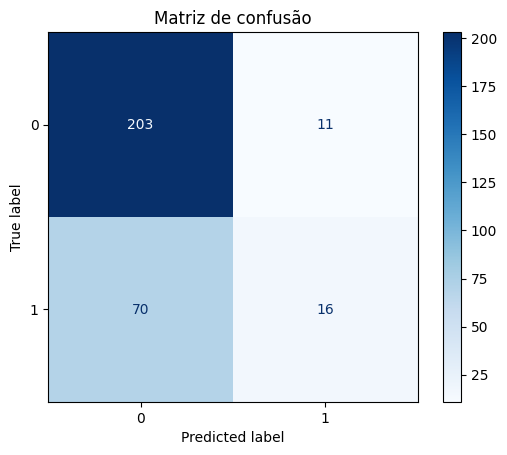

----------------------------------------------------------------------------------------------------
Métricas:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       214
           1       0.59      0.19      0.28        86

    accuracy                           0.73       300
   macro avg       0.67      0.57      0.56       300
weighted avg       0.70      0.73      0.68       300

----------------------------------------------------------------------------------------------------


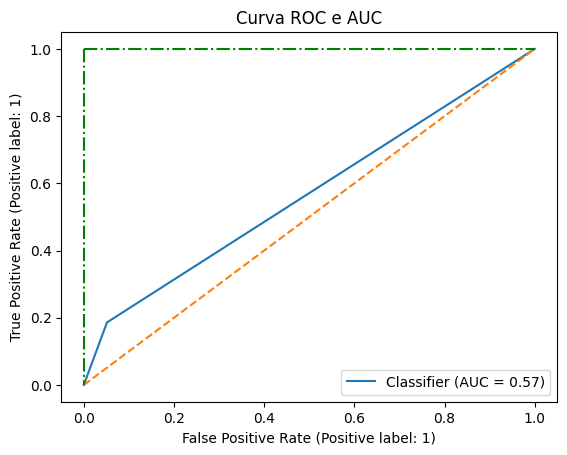

In [51]:
selected_cols = [
    'default',
    'prazo_emprestimo_meses', 
    'valor_emprestimo',
    'proposito_emprestimo_(vacation - does not exist?)',
    'proposito_emprestimo_business', 'proposito_emprestimo_car (new)',
    'proposito_emprestimo_car (used)',
    'proposito_emprestimo_domestic appliances',
    'proposito_emprestimo_education',
    'proposito_emprestimo_furniture/equipment',
    'proposito_emprestimo_radio/television', 
    'proposito_emprestimo_repairs',
    'proposito_emprestimo_retraining',
    'tempo_emprego_atual_.. >= 7 years',
    'tempo_emprego_atual_... < 1 year ',
    'tempo_emprego_atual_1 <= ... < 4 years',
    'tempo_emprego_atual_4 <= ... < 7 years',
    'tempo_emprego_atual_unemployed',
    'status_emprego_management/ self-employed/ highly qualified employee/ officer',
    'status_emprego_skilled employee / official',
    'status_emprego_unemployed/ unskilled - non-resident',
    'status_emprego_unskilled - resident',
    'estado_civil'
]
small_df = df_enc[selected_cols]

run_classifier(small_df, LogisticRegression(max_iter=1000))

Criando uma nova base, agrupando alguns dados em faixas de classificação:

Idade:

- 18 a 30 = 0

- 31 a 40 = 1

- 41 a 50 = 2

- 51 a 60 = 3

- 61 a 70 = 4

- 71 a 80 = 5

In [56]:
df_binned = df_enc.drop('idade', axis=1)
df_binned['faixa_etaria'] = pd.cut(x=df_enc['idade'], bins=[18,30,40,50,60,70,80], labels=[0,1,2,3,4,5])
df_binned.head()

,default,prazo_emprestimo_meses,valor_emprestimo,taxa_comp_salario,anos_residencia_atual,n_creditos_banco,n_dependentes,conta_corrente_0 <= ... < 200 DM,conta_corrente_< 0 DM,conta_corrente_>= 200 DM / salary assignments for at least 1 year,...,tipo_residencia_own,tipo_residencia_rent,status_emprego_management/ self-employed/ highly qualified employee/ officer,status_emprego_skilled employee / official,status_emprego_unemployed/ unskilled - non-resident,status_emprego_unskilled - resident,"telefone_yes, registered under the customers name",trabalhador_estrangeiro_yes,estado_civil,faixa_etaria
0,0,6,1169,4,4,2,1,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,4
1,1,48,5951,2,2,1,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0
2,0,12,2096,2,3,1,2,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,2
3,0,42,7882,2,4,1,2,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,2
4,1,24,4870,3,4,2,2,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,3


Prazo do empréstimo:

- 01 a 12: 0

- 13 a 24: 1

- 25 a 36: 2

- 37 a 48: 3

- 49 a 60: 4

- 61 a 72: 5

In [57]:
df_binned['prazo_emprestimo_meses'] = pd.cut(x=df_binned['prazo_emprestimo_meses'], bins=[1,12,24,36,48,60,72], labels=[0,1,2,3,4,5])
df_binned.head()

,default,prazo_emprestimo_meses,valor_emprestimo,taxa_comp_salario,anos_residencia_atual,n_creditos_banco,n_dependentes,conta_corrente_0 <= ... < 200 DM,conta_corrente_< 0 DM,conta_corrente_>= 200 DM / salary assignments for at least 1 year,...,tipo_residencia_own,tipo_residencia_rent,status_emprego_management/ self-employed/ highly qualified employee/ officer,status_emprego_skilled employee / official,status_emprego_unemployed/ unskilled - non-resident,status_emprego_unskilled - resident,"telefone_yes, registered under the customers name",trabalhador_estrangeiro_yes,estado_civil,faixa_etaria
0,0,0,1169,4,4,2,1,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,4
1,1,3,5951,2,2,1,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0
2,0,0,2096,2,3,1,2,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,2
3,0,3,7882,2,4,1,2,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,2
4,1,1,4870,3,4,2,2,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,3


Valor do empréstimo: de mil em mil euros, a partir de 1 até 20000

In [58]:
df_binned['valor_emprestimo'] = pd.cut(
    x=df_binned['valor_emprestimo'], 
    bins=[1,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000], 
    labels=[0,1,2,3,4,5,6,7,8,9,10,12,11,13,14,15,16,17,18,19])
df_binned.head()

,default,prazo_emprestimo_meses,valor_emprestimo,taxa_comp_salario,anos_residencia_atual,n_creditos_banco,n_dependentes,conta_corrente_0 <= ... < 200 DM,conta_corrente_< 0 DM,conta_corrente_>= 200 DM / salary assignments for at least 1 year,...,tipo_residencia_own,tipo_residencia_rent,status_emprego_management/ self-employed/ highly qualified employee/ officer,status_emprego_skilled employee / official,status_emprego_unemployed/ unskilled - non-resident,status_emprego_unskilled - resident,"telefone_yes, registered under the customers name",trabalhador_estrangeiro_yes,estado_civil,faixa_etaria
0,0,0,1,4,4,2,1,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,4
1,1,3,5,2,2,1,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0
2,0,0,2,2,3,1,2,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,2
3,0,3,7,2,4,1,2,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,2
4,1,1,4,3,4,2,2,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,3


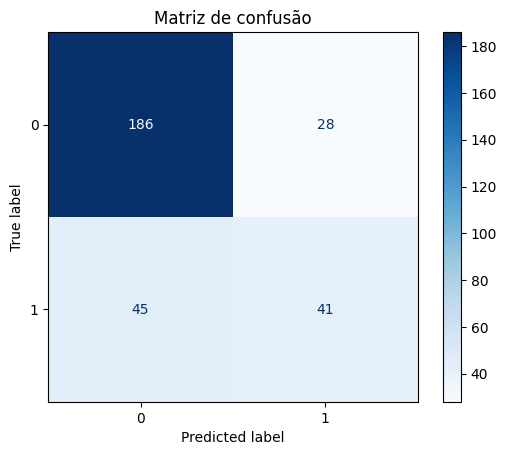

----------------------------------------------------------------------------------------------------
Métricas:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       214
           1       0.59      0.48      0.53        86

    accuracy                           0.76       300
   macro avg       0.70      0.67      0.68       300
weighted avg       0.74      0.76      0.75       300

----------------------------------------------------------------------------------------------------


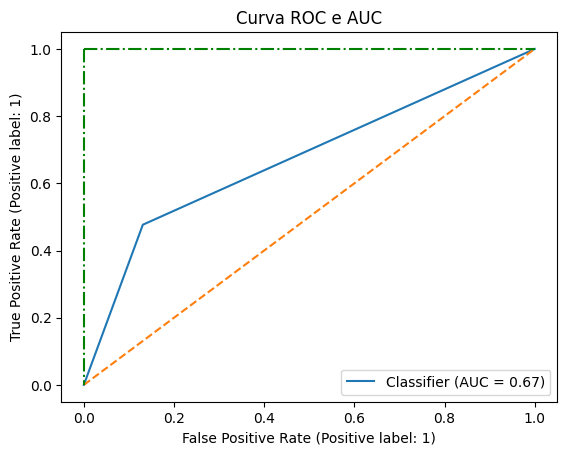

In [59]:
run_classifier(df_binned, LogisticRegression(max_iter=1000))

Avaliando outros classificadores:

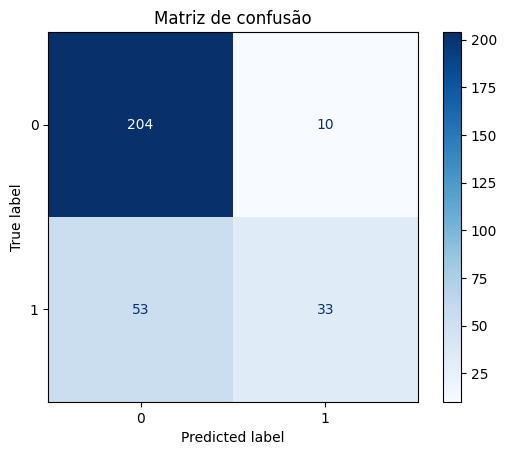

----------------------------------------------------------------------------------------------------
Métricas:
              precision    recall  f1-score   support

           0       0.79      0.95      0.87       214
           1       0.77      0.38      0.51        86

    accuracy                           0.79       300
   macro avg       0.78      0.67      0.69       300
weighted avg       0.79      0.79      0.76       300

----------------------------------------------------------------------------------------------------


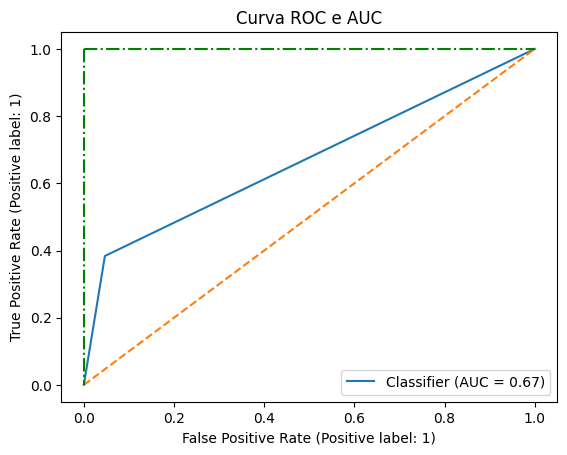

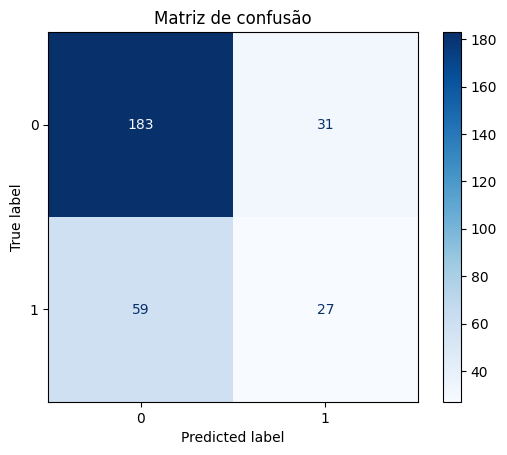

----------------------------------------------------------------------------------------------------
Métricas:
              precision    recall  f1-score   support

           0       0.76      0.86      0.80       214
           1       0.47      0.31      0.37        86

    accuracy                           0.70       300
   macro avg       0.61      0.58      0.59       300
weighted avg       0.67      0.70      0.68       300

----------------------------------------------------------------------------------------------------


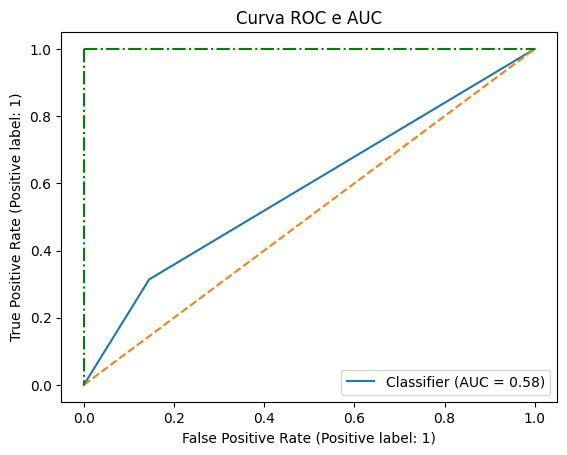

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
run_classifier(df_enc, RandomForestClassifier(max_depth=50))
run_classifier(df_enc, KNeighborsClassifier())